### Loading Dataset

In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(SummarizedExperiment))

saveDir <- "environment/real_datasets/GSE100505_EDL_MAST/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/DE"
load(file.path(saveDir, "tseConsUp.RData"))
load(file.path(saveDir, "bSwishCons_OL.RData"))
treeCons <- rowTree(tseConsUp)
l <- length(treeCons$tip)

#### Transcript level analysis

In [2]:
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/SRR_Acc_List.txt")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
samples <- metaData$RUN
files <- file.path(quantDir, samples, "quant.sf")
colData <- cbind(data.frame(files = files, names = samples), condition = as.factor(metaData$TissueName))
seMuscle <- tximeta::tximeta(colData)

importing quantifications

reading in files with read.delim (install 'readr' package for speed up)

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 


found matching transcriptome:
[ GENCODE - Mus musculus - release M25 ]

loading existing TxDb created: 2023-02-17 18:26:37

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

loading existing transcript ranges created: 2023-02-17 18:26:39

fetching genome info for GENCODE



In [3]:
y <- fishpond::scaleInfReps(tseConsUp[1:l,])
y <- labelKeep(y)
set.seed(10)
y <- swish(y, x="condition")

In [4]:
getLog2FC <- function(infRepsArray, condition, pc = 5) {
  dims <- dim(infRepsArray)
  cond1 <- condition == levels(condition)[1]
  cond2 <- condition == levels(condition)[2]
  diffs <- matrix(nrow = dims[1], ncol = dims[3])
  for (k in seq_len(dims[3])) {
    diffs[, k] <-
      log2(rowMeans(infRepsArray[, cond2, k]) + pc) - log2(rowMeans(infRepsArray[
        ,
        cond1, k
      ]) + pc)
  }

  # median over inferential replicates
  rowMedians(diffs)
}

In [5]:
yAll <- computeSizeFactors(tseConsUp)
yAll <- scaleInfReps(yAll)
yAll <- labelKeep(yAll)
set.seed(10)
yInn <- swish(yAll[(l+1):nrow(yAll),], x="condition")

Setting inf rep depth to mean depth



Progress:   1 on 100Progress:   2 on 100Progress:   3 on 100Progress:   4 on 100Progress:   5 on 100Progress:   6 on 100Progress:   7 on 100Progress:   8 on 100Progress:   9 on 100Progress:  10 on 100Progress:  11 on 100Progress:  12 on 100Progress:  13 on 100Progress:  14 on 100Progress:  15 on 100Progress:  16 on 100Progress:  17 on 100Progress:  18 on 100Progress:  19 on 100Progress:  20 on 100Progress:  21 on 100Progress:  22 on 100Progress:  23 on 100Progress:  24 on 100Progress:  25 on 100Progress:  26 on 100Progress:  27 on 100Progress:  28 on 100Progress:  29 on 100Progress:  30 on 100Progress:  31 on 100Progress:  32 on 100Progress:  33 on 100Progress:  34 on 100Progress:  35 on 100Progress:  36 on 100Progress:  37 on 100Progress:  38 on 100Progress:  39 on 100Progress:  40 on 100Progress:  41 on 100Progress:  42 on 100Progress:  43 on 100Progress:  44 on 100Progress:  45 on 100Progress:  46 on 100Progress:  47 on 100Progress:  48 on 100Progress:  49 on 100Progress:  50 on 100

In [6]:
infRepInds <- grep("infRep", assayNames(yAll))
infReps <- assays(yAll)[infRepInds]
infReps <- abind::abind(as.list(infReps), along = 3)
mcols(yAll)[["log2FC"]] <- getLog2FC(infReps, colData(yAll)[["condition"]])

In [7]:
pvals <- c(mcols(y)[["pvalue"]], mcols(yInn)[["pvalue"]])
adjust <- p.adjust(pvals, "BH")
mcols(yAll)[["qvalue"]] <- adjust

##### Differentially Expressed Transcripts

In [8]:
sapply(c(0.01,0.05,0.1), function(x) sum(mcols(y)[["qvalue"]] <= x, na.rm=T))
dTxps <- lapply(c(0.01,0.05,0.1), function(x) rownames(y)[which(mcols(y)[["qvalue"]] <= x)])
# save(dTxps, file=file.path(saveDir, "dTxps.RData"))

[1] 3149 6849 9592

##### Genes Mapping to those transcripts

In [9]:
mapDf <- rowData(seMuscle)
txpGenes <- lapply(dTxps, function(txps) unique(unlist(mapDf[txps, "gene_id"])))##Genes that map to transcripts
sapply(txpGenes, length)

[1] 2685 5391 7121

#### Gene Level

In [10]:
gse <- summarizeToGene(seMuscle)
yg <- fishpond::scaleInfReps(gse)
yg <- labelKeep(yg)
set.seed(10)
yg <- swish(yg, x="condition")

loading existing TxDb created: 2023-02-17 18:26:37

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-02-21 05:37:24

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



##### Differentially expressed genes

In [11]:
dges <- lapply(c(0.01,0.05,0.1), function(x) rownames(yg)[which(mcols(yg)[["qvalue"]] <= x)])
sapply(dges, length)
# save(dges, file=file.path(saveDir, "dges.RData"))

[1] 2535 4494 5814

##### Genes that are considered differentially expressed in genes but dont contain a single differentially expressed transcript

In [12]:
diffGenes <- lapply(seq_along(dges), function(i) setdiff(dges[[i]], txpGenes[[i]])) ## Txps that are missing in differential transcripts mapping to genes
sapply(diffGenes, length)
diffGenes2 <- lapply(seq_along(dges), function(i) setdiff(txpGenes[[i]], dges[[i]])) ## Txps that are missing in differential transcripts mapping to genes                    
sapply(diffGenes2, length)
# sum(mcols(y)[unlist(mcols(yg)[diffGenes[[2]],"tx_ids"]), "qvalue"] < 0.05, na.rm=T)==0 ## None of the diffGenes should contain a differential transcript

[1] 685 839 907

[1]  835 1736 2214

#### Terminus

In [13]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/real_datasets/GSE100505_EDL_MAST/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/SRR5758630/clusters.txt"
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseConsUp[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
yTerm <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yAggTermThrNS)
yTerm <- labelKeep(yTerm)
set.seed(10)
yTerm <- swish(yTerm, x="condition")

#### TreeDE, with the total number of nodes, inner nodes and their height distribution

In [14]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
treeDE <- treeDEFDR_OL[["mIRV=0.4"]] ## renaming the treeDE variable
sapply(treeDE, length) ## number of differentially expressed nodes
sapply(treeDE, function(nodes) sum(nodes > l)) ## number of inner nodes
lapply(treeDE, function(nodes) table(node.depth(treeCons,2)[nodes])) ## Distribution of node heights

[1]  3711  7693 10458

[1] 1189 2287 2958

[[1]]

   1    2    3    4    5    6    7    8    9   10   11 
2522  651  295  134   59   28    8    7    4    1    2 

[[2]]

   1    2    3    4    5    6    7    8    9   10   11   13 
5406 1285  555  252  107   46   20   11    4    1    3    3 

[[3]]

   1    2    3    4    5    6    7    8    9   10   11   12   13 
7500 1698  696  308  130   62   31   17    6    4    3    1    2 


In [15]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["treeDEFDR_OL"]] <- lapply(treeDEFDR_OL[["mIRV=0.4"]], function(ta) ta)
detNodes[["treeClimbR"]] <- lapply(bSwish, function(sw) sw$output[sw$output$signal.node,][["node"]])
detNodes[["treeClimbRO"]] <- lapply(bSwish, function(sw) unlist(Descendants(treeCons,sw$output[sw$output$signal.node,][["node"]])))
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(yAggTermThrNS))
    })

In [16]:
treeDETxps <- rownames(tseConsUp)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[3]]))]
treeClimbTxps <- rownames(tseConsUp)[unlist(Descendants(treeCons, detNodes[["treeClimbR"]][[3]]))]

dN <- detNodes[["term"]][[3]]

termTxps <- c(rownames(yAggTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

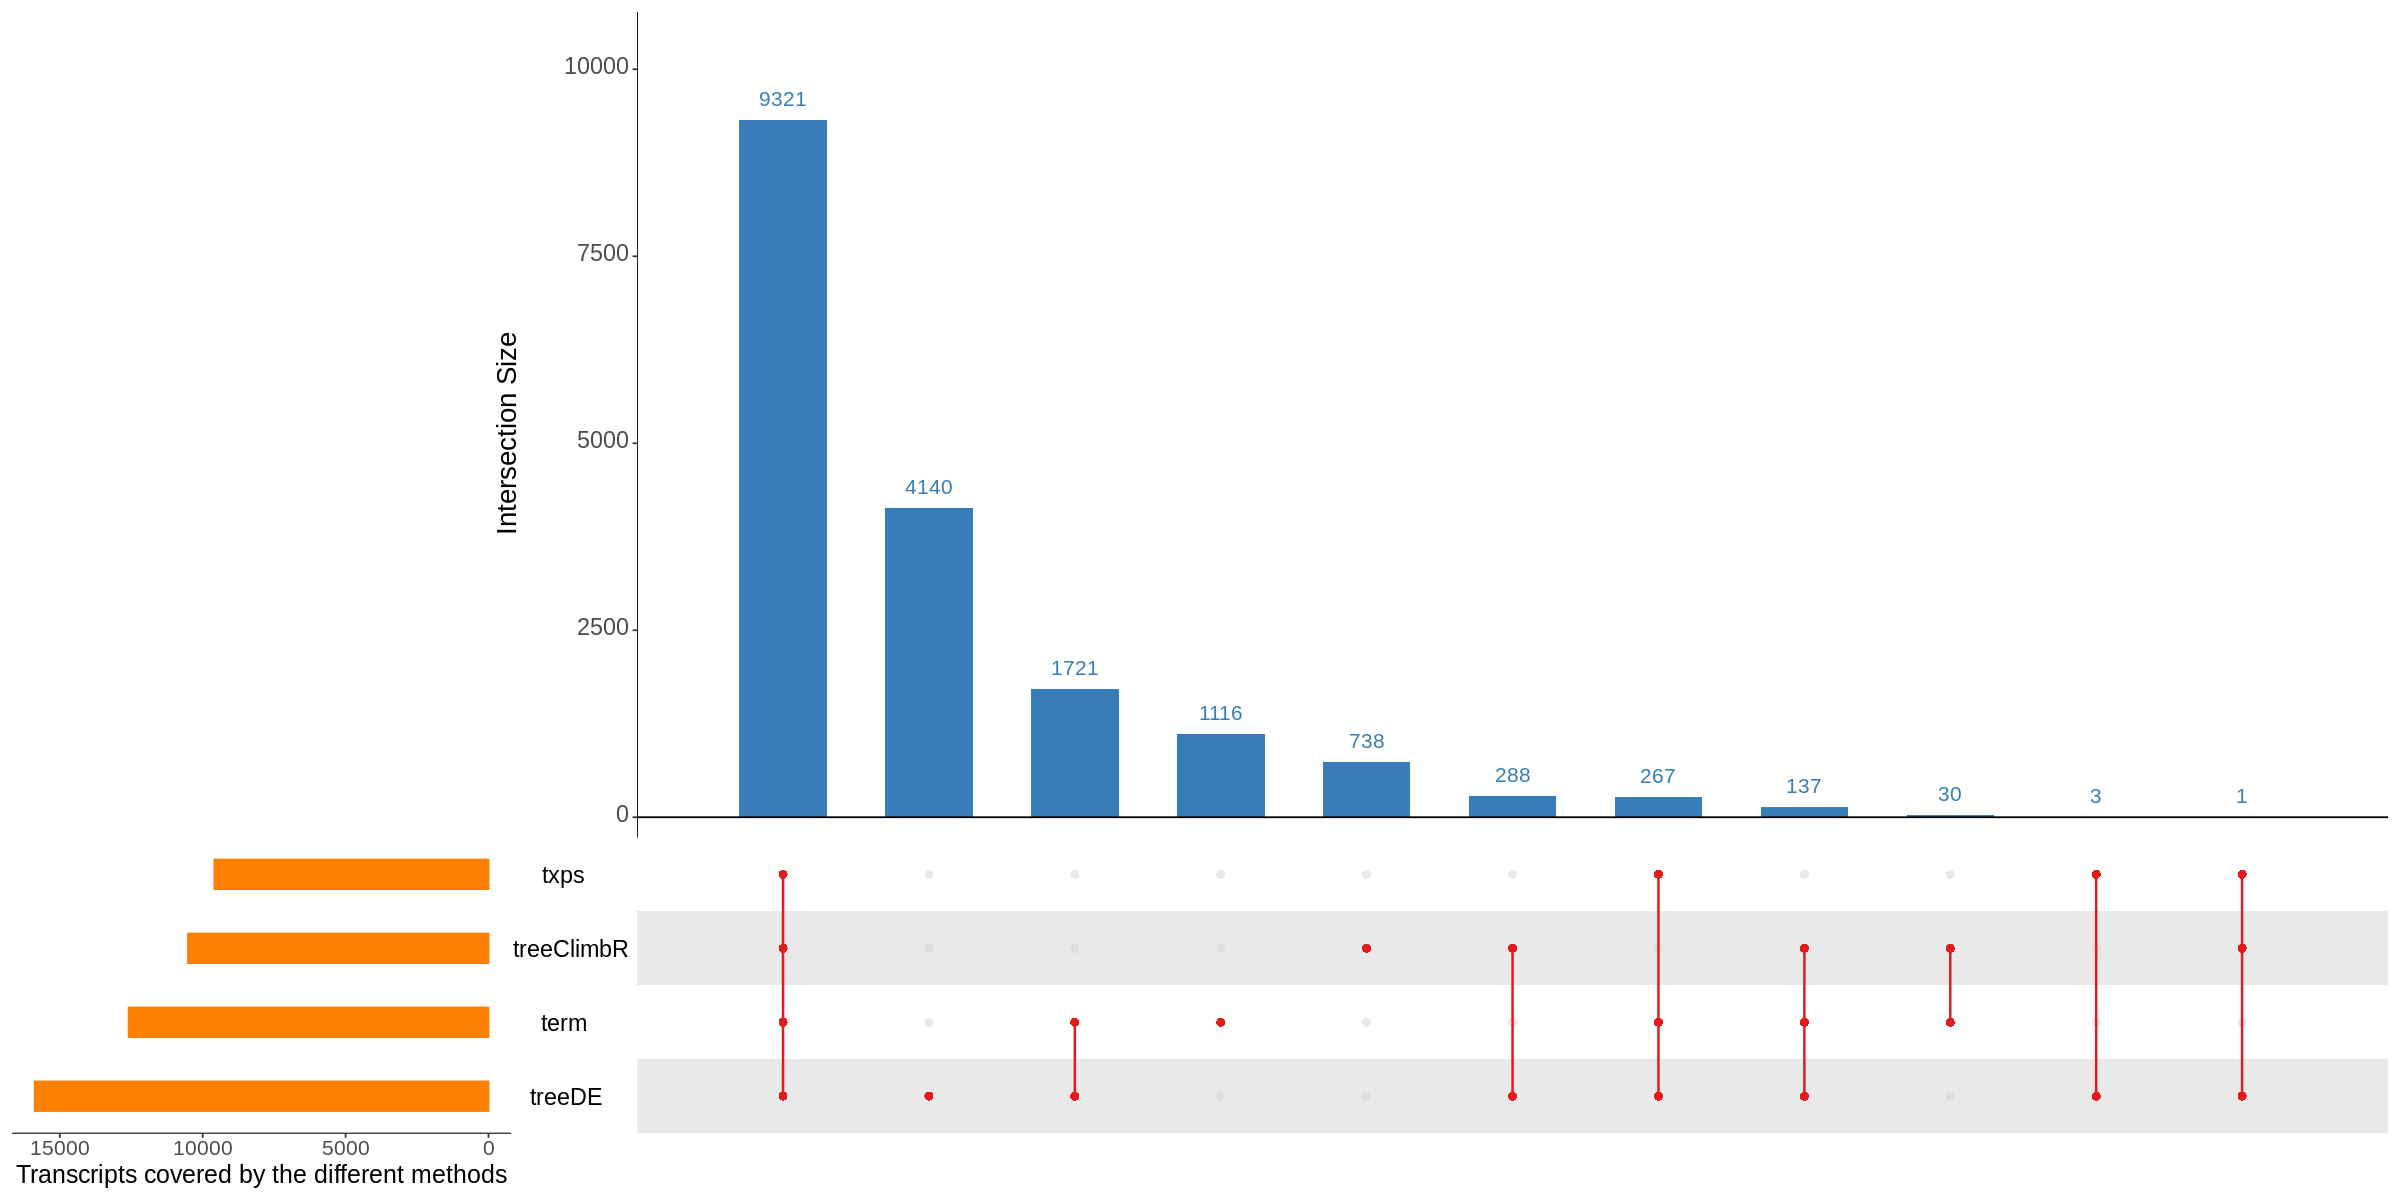

In [41]:
options(repr.plot.width=20, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(txps = dTxps[[3]], 
                 treeDE = treeDETxps, 
                 treeClimbR = treeClimbTxps, 
                 term = termTxps)
upsetData <- fromList(txpMethods)
size <- 2
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by the different methods",
     shade.alpha = 0.7, 
     text.scale = c(size, size, 1.8, 1.8, size, size)
)

In [43]:
##### Genes mapping to the treeClimbR nodes and their number

[1] 1021

In [44]:
genesTreeDE <- lapply(detNodes[["treeClimbR"]], function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTreeDE, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTreeDE, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 2731 5423 7117

[[1]]

   1    2    3    4    5    6    8 
2872   25    4    4    2    1    1 

[[2]]

   1    2    3    4    5    6    8   11 
6046   50    7    4    2    2    2    1 

[[3]]

   1    2    3    4    5    6    7    8   11 
8390   57   10    4    2    2    1    3    1 


##### Genes mapping to the treeDE nodes and their number

In [23]:
genesTreeDE <- lapply(treeDE, function(nodes) {
    lapply(Descendants(treeCons,nodes), function(desc) unique(unlist(mapDf[treeCons$tip[desc],"gene_id"])))})
sapply(genesTreeDE, function(genes) length(unique(unlist(genes)))) ## Number of genes mapping to treeDE nodes
sapply(genesTreeDE, function(nodes) table(sapply(nodes,length))) ## Distribution of number of genes and nodes

[1] 3255 6220 8010

[[1]]

   1    2    3    5 
3672   33    5    1 

[[2]]

   1    2    3    4 
7625   56    8    4 

[[3]]

    1     2     3     4     7     9 
10369    73     9     4     1     2 


#### Gene Families for these genes

In [ ]:
genes <- unlist(lapply(strsplit(unlist(genesTreeDE[[3]]), ".", fixed=T), function(x) x[[1]]))
names(genes) <- unlist(genesTreeDE[[3]])

In [ ]:
# iN <- which(sapply(genesTreeDE[[3]],length)>=2)
# genesTreeDE[[3]][[iN[2]]]
library(biomaRt)
ensembl <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
selected_attributes <- c("ensembl_gene_id", "external_gene_name")
gene_info <- getBM(attributes = selected_attributes, filters = "ensembl_gene_id", mart = ensembl, values = unlist(genes))
head(gene_info)

In [ ]:
gs <- genesTreeDE[[3]][sapply(genesTreeDE[[3]],length)>=2]

In [18]:
length(gs)
for(i in seq_along(gs)) {
        print(gene_info[match(genes[gs[[i]]],gene_info$ensembl_gene_id),2])
}

[1] 89

[1] "Bcl2a1d" "Bcl2a1a"
[1] "Rps7"     "Rps7-ps3"
[1] "Gm13237" "Gm4739" 
[1] "Gm7334" "Btg3"  
[1] "Nat8f3" "Nat8f7"
[1] "Ugt1a10" "Ugt1a9"  "Ugt1a8"  "Ugt1a5"  "Ugt1a2"  "Ugt1a1"  "Ugt1a6b"
[8] "Ugt1a6a" "Ugt1a7c"
[1] "Zc3h3"  "Gm7353"
[1] "Rpl3"     "Rpl3-ps1"
[1] "Hacl1"   "Gm49387"
[1] "Gvin1" "Gvin2"
[1] "Gm14176" "Gm5931" 
[1] "Bnip3l-ps" "Bnip3l"   
[1] "Rmi1"    "Gm20775"
[1] "Meg3"    "Gm27000"
[1] "Nnt" "Nnt"
[1] "Tpt1"     "Tpt1-ps3"
[1] "Pcdhgb6" "Pcdhga4"
[1] "Pcdhga12" "Pcdhgb7" 
[1] "Pcdhgb8" "Pcdhga2"
[1] "Ube2s"  "Gm2296"
[1] "Xntrpc" "Trpc2" 
[1] "Zfp82"   "Gm26920"
[1] "Gm12416" "Gm5944"  "Gm3534"  "Gm2308"  "Gm4217"  "Gm7251"  "Gm4518" 
[8] "Gm10290" "Gm8349" 
[1] "Gm8055"  "Gm11953"
[1] "Gm16534" "Fam78a" 
[1] "Prn"  "Prnd"
[1] "Hdhd2" NA     
[1] "Pakap" "Pakap"
[1] "Hmgb1"   "Gm21596"
[1] "Flad1" "Lenep"
[1] "Rpl36a"     "Rpl36a-ps1" "Rpl36a-ps2"
[1] "Arfip1"  "Gm37240"
[1] "Glcci1"  "Gm45062"
[1] "Rsph3a" "Rsph3b"
[1] "Nap1l1" "Gm4204"
[1] "Mbtps2" "Yy2"   
[1]

#### Genes that map only to treeDE but are neither DE or covered by differential transcripts

In [24]:
innerNodesUniqueGenes <- lapply(seq_along(genesTreeDE), function(i) setdiff(unlist(genesTreeDE[[i]]), union(dges[[i]], txpGenes[[i]])))
head(innerNodesUniqueGenes[[2]]) 
sapply(innerNodesUniqueGenes, length)

[1] "ENSMUSG00000024608.11" "ENSMUSG00000030428.16" "ENSMUSG00000018920.11"
[4] "ENSMUSG00000028651.12" "ENSMUSG00000056014.15" "ENSMUSG00000061477.4"

[1] 264 405 428

Such inner nodes can be possible DTUs. We thus extract the treeDE nodes to which these genes map to and try to see if there are multiple such tree DE nodes that map to same gene.Looking at the 0.1 threshold change, we find only 2 gene for which a dtu on the inner nodes is observed.

For the remaining that have map to inner node, infRV decreases compared to their children though the logFC is lower compared to children. logFC though definitely decreases at gene.

In [45]:
qval <- 0.1
i <- 3
gN <- innerNodesUniqueGenes[[i]][which(mcols(yg)[innerNodesUniqueGenes[[i]],"qvalue"] > qval)]
length(gN)

# extracting genes unique to treeDE and have logFC > 0.5 or have atleast two sig nodes
twoNodes <- list()
lfcNodes <- c()
j <- 1
for(g in gN) {
    iid <- which(sapply(genesTreeDE[[i]], function(genes) sum(g %in%  genes) > 0))
    if(length(iid) > 1) {
        twoNodes[[j]] <- iid
        j <- j + 1
    }
    else if(length(which(abs(mcols(yAll)[treeDE[[2]][iid],"log2FC"]) > 0.5)) > 0) {
        lfcNodes <- c(lfcNodes, iid)
    }
}
length(twoNodes)
length(lfcNodes)

[1] 389

[1] 0

[1] 4

##### DTU

In [ ]:
##Follow up analysis
## (1,2) map to more than 1 gene
## 4,5,6 shows no dtu
for(j in seq_along(twoNodes)) {
        gs <- genesTreeDE[[2]][[twoNodes[[j]][1]]]
genesTreeDE[[2]][[twoNodes[[j]][2]]]

print("Gene Level")
print(mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")])

print("TreeDE Node 1")
print(cbind(mcols(yAll)[treeDE[[2]][twoNodes[[j]][1]],], qval = adjust[treeDE[[2]][twoNodes[[j]][[1]]]]))
print("Transcripts mapping TreeDE Node 1")
print(cbind(mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][1]])),], 
      qval = adjust[unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][1]]))]))

print("TreeDE Node 2")
print(cbind(mcols(yAll)[treeDE[[2]][twoNodes[[j]][2]],],
     qval = adjust[treeDE[[2]][twoNodes[[j]][[2]]]]))
print("Transcripts mapping TreeDE Node 2")
print(cbind(mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][2]])),], 
      qval = adjust[unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][2]]))]))
    
    print("new")
}


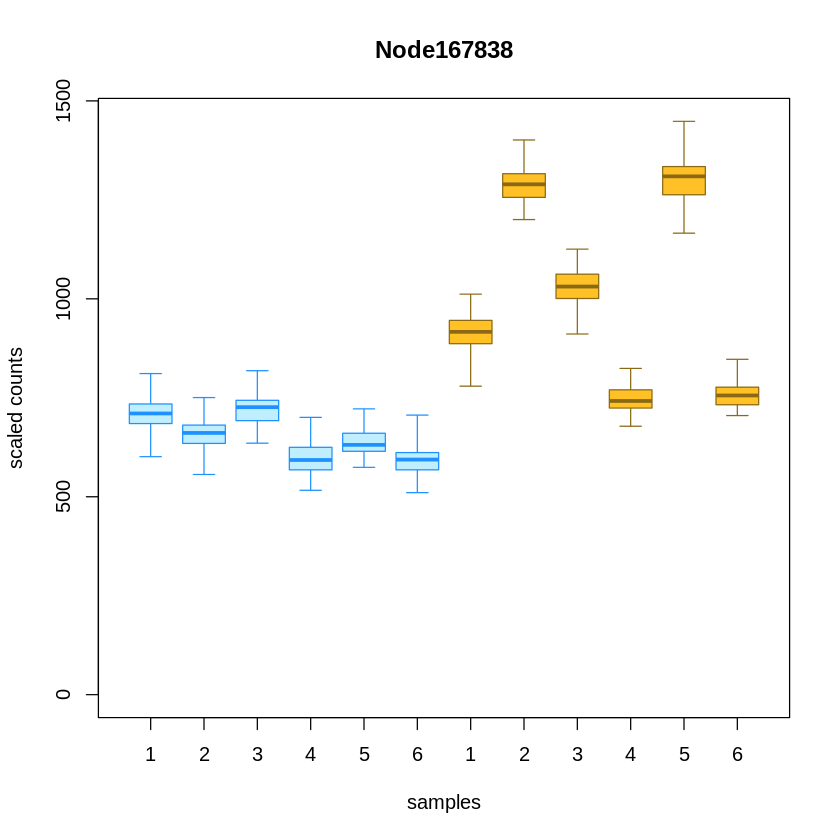

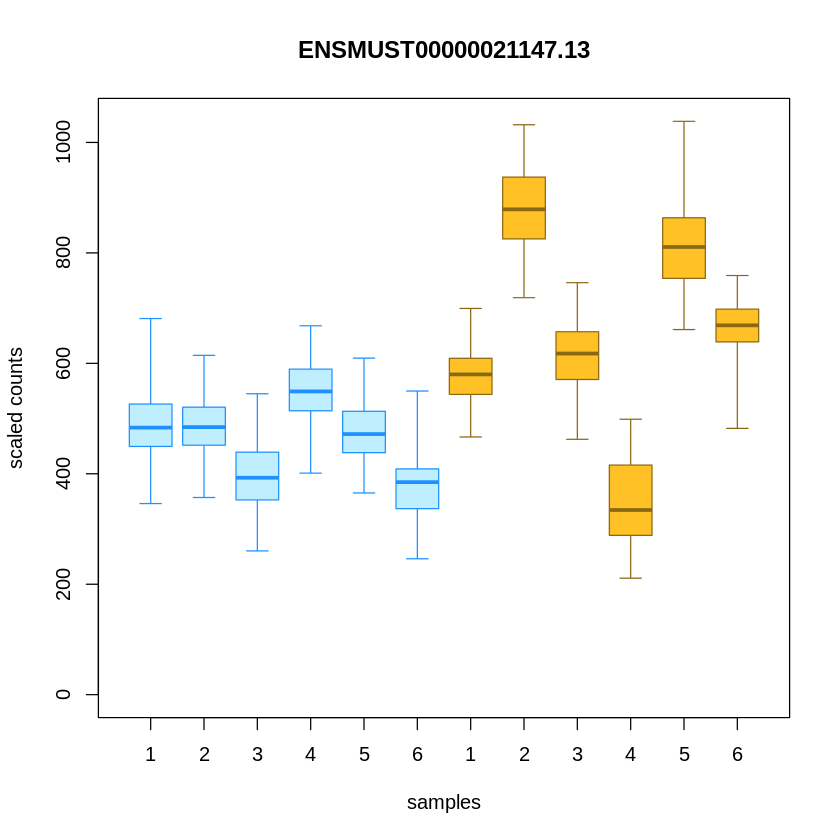

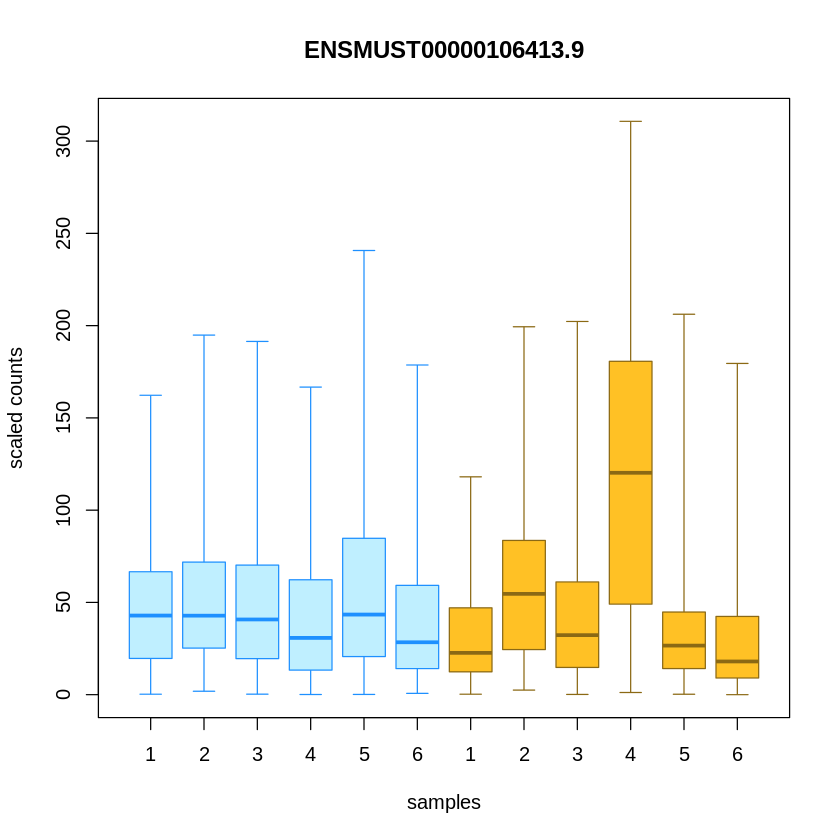

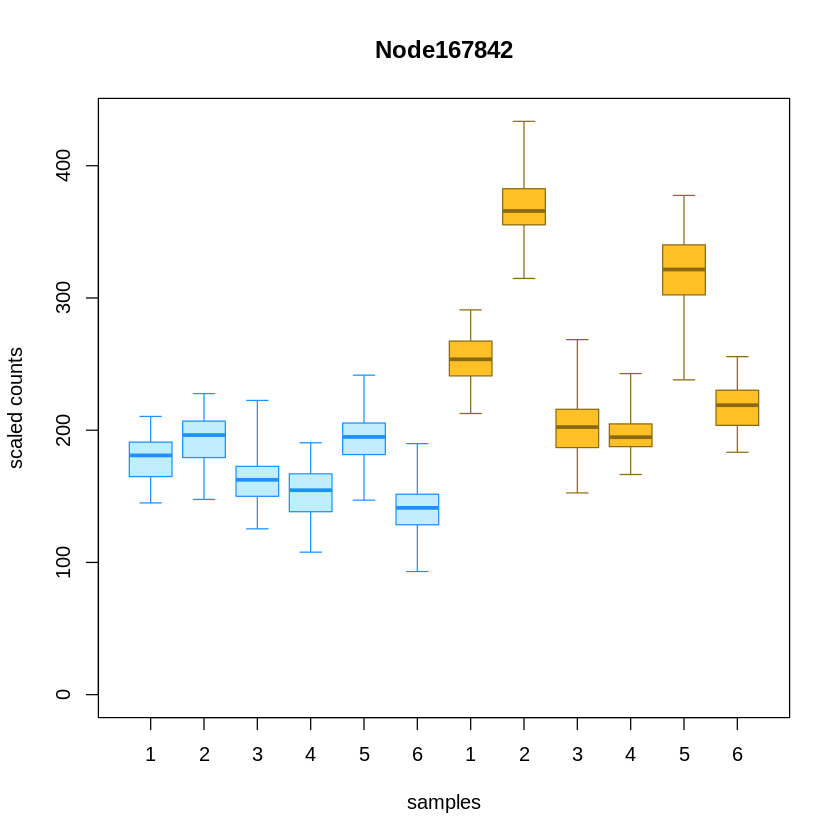

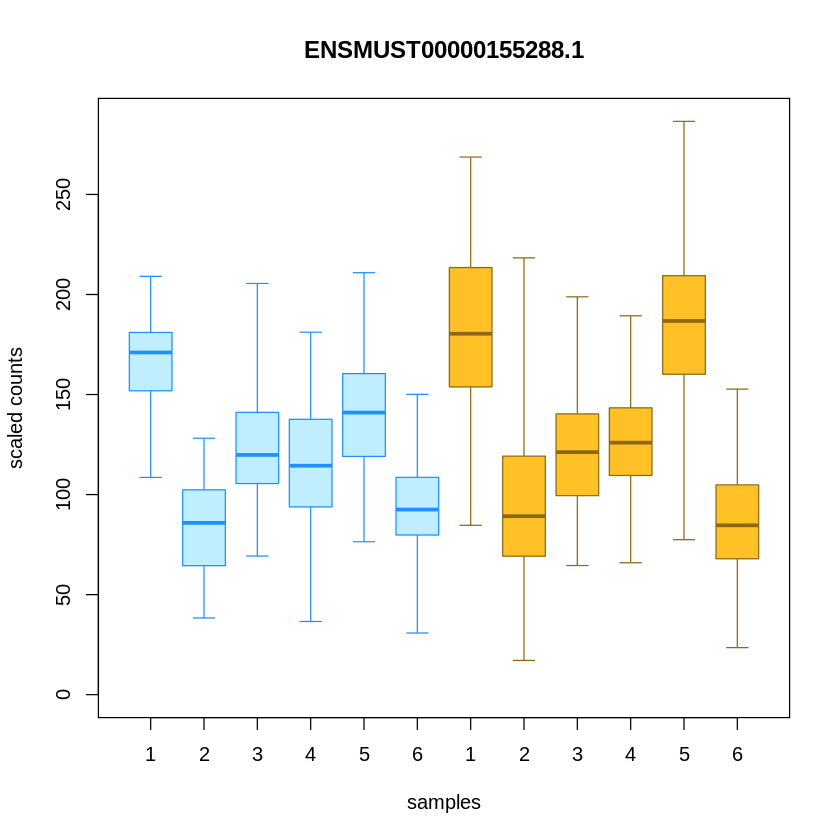

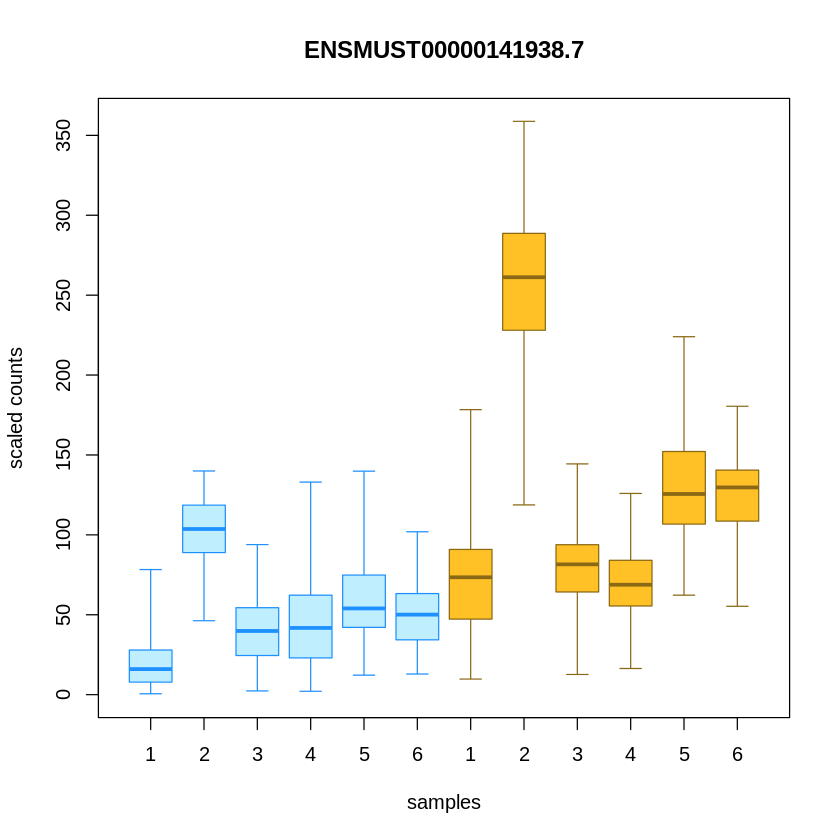

In [21]:
plotInfReps(y=yAll, x = "condition", idx = treeDE[[2]][twoNodes[[j]][1]])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][1]]))[1])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][1]]))[2])

plotInfReps(y=yAll, x = "condition", idx = treeDE[[2]][twoNodes[[j]][2]])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][2]]))[1])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][twoNodes[[j]][2]]))[2])

##### Other example of the above genes that however show no dtu

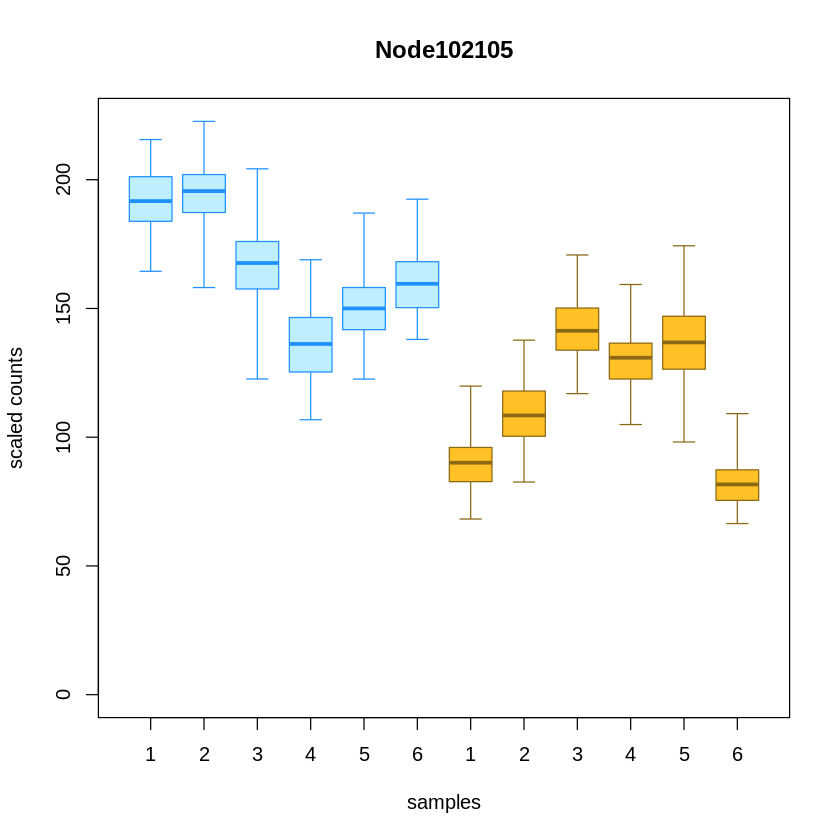

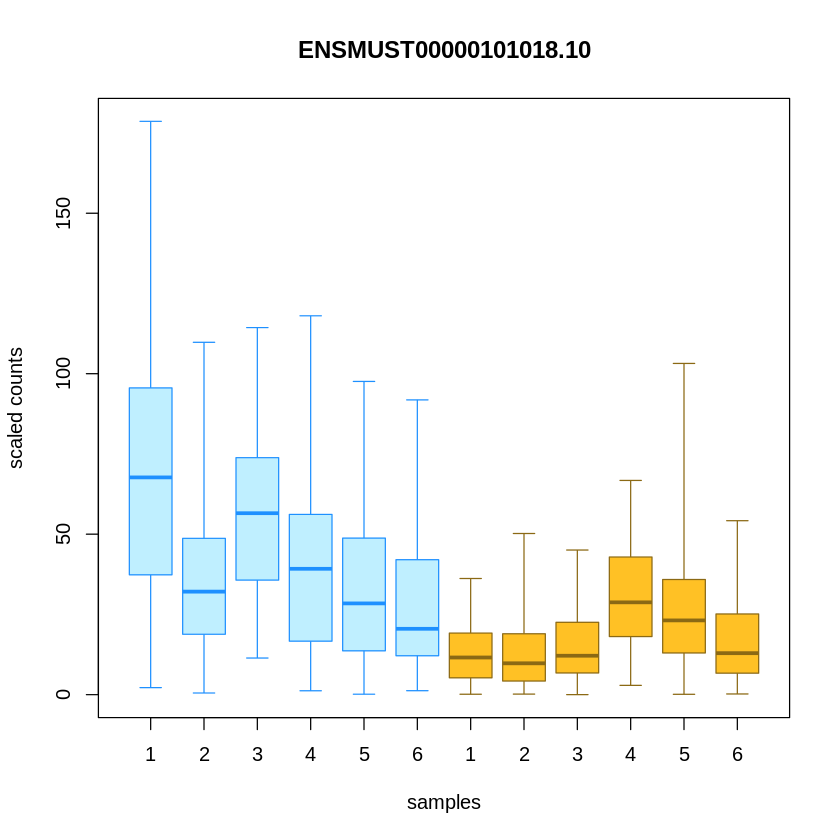

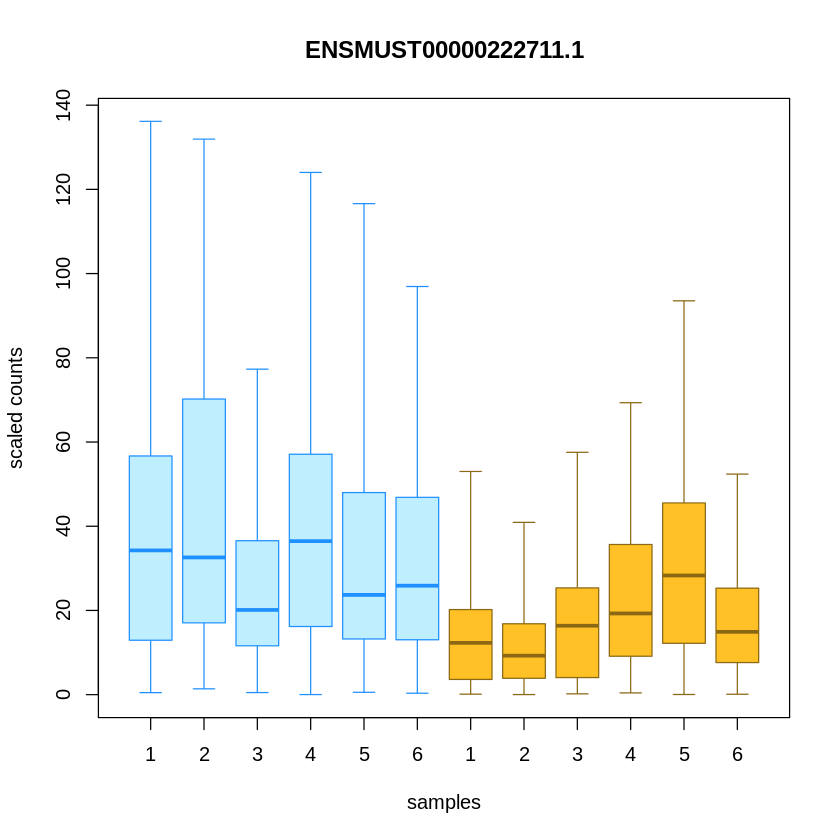

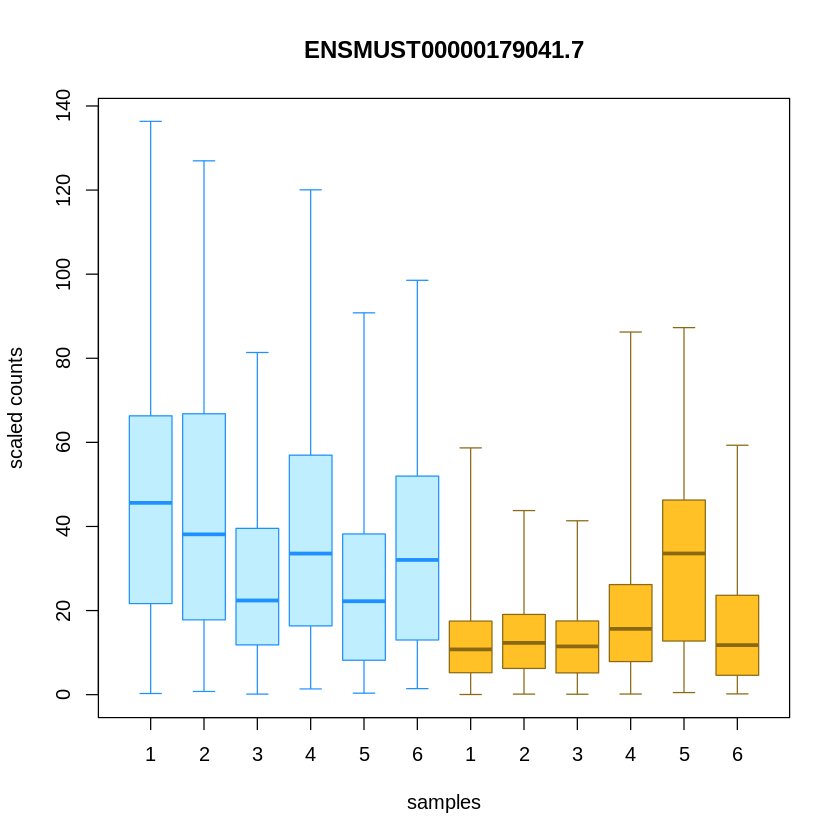

In [22]:
plotInfReps(y=yAll, x = "condition", idx = treeDE[[2]][lfcNodes[j]])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]]))[1])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]]))[2])
plotInfReps(y=yAll, x = "condition", idx = unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]]))[3])

In [23]:
## A lowering of the LFC but also along with a substantial decrease in infRV
## Some of these nodes map to multiple genes some of which are DEs
head(order(mcols(yAll)[treeDE[[2]][lfcNodes],"log10mean"], decreasing=T), 30)
j <- 118
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
print(gs)
mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")]
mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]
print("j")

j <- 25
gs <- genesTreeDE[[2]][[lfcNodes[j]]]
mcols(yg)[gs,c("log10mean", "log2FC")]
mcols(yAll)[cbind(treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")),]
mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]
print("j")
# j <- 142
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# mcols(yg)[gs,c("log10mean", "log2FC")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC")]
# mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]

# j <- 143
# gs <- genesTreeDE[[2]][[lfcNodes[j]]]
# mcols(yg)[gs,c("log10mean", "log2FC", "qvalue")]
# mcols(yAll)[treeDE[[2]][lfcNodes[j]],c("meanInfRV", "log10mean", "log2FC", "qvalue")]
# mcols(yAll)[unlist(Descendants(treeCons,treeDE[[2]][lfcNodes[j]])),c("meanInfRV", "log10mean", "log2FC")]

[1] 118  25 142 143  65 188  50   5 158  61  21  69 135 222 194  98  48 213  64
[20] 147 113 208 105  31  67  19  91 125 156 116

[1] "ENSMUSG00000038717.8"


DataFrame with 1 row and 3 columns
                     log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric>
ENSMUSG00000038717.8   3.88265  0.200366  0.614476

DataFrame with 1 row and 3 columns
           meanInfRV log10mean    log2FC
           <numeric> <numeric> <numeric>
Node135025  0.878695   3.76715 -0.525694

DataFrame with 2 rows and 3 columns
                     meanInfRV log10mean    log2FC
                     <numeric> <numeric> <numeric>
ENSMUST00000213999.1   1.82022   3.59143 -0.571328
ENSMUST00000043675.8   4.11910   3.30611 -0.457364

[1] "j"


DataFrame with 1 row and 2 columns
                      log10mean    log2FC
                      <numeric> <numeric>
ENSMUSG00000022565.15    4.0153  -1.38563

Warning message in NSBS(i, x, exact = exact, strict.upper.bound = !allow.append, :
"subscript is an array, passing it thru as.vector() first"


DataFrame with 6 rows and 5 columns
     meanInfRV log10mean      keep    log2FC    qvalue
     <numeric> <numeric> <logical> <numeric> <numeric>
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA
<NA>        NA        NA        NA        NA        NA

DataFrame with 3 rows and 3 columns
                      meanInfRV log10mean    log2FC
                      <numeric> <numeric> <numeric>
ENSMUST00000074834.11   258.479   3.09477  -1.42773
ENSMUST00000169108.7    324.507   3.17899  -1.25254
ENSMUST00000169438.7    361.319   2.66116  -1.04827

[1] "j"


#### Genes belonging to treeDE nodes that intersect with differentially expressed genes but are not covered by transcripts.'
We see many such genes that contain differential nodes but no differentially expressed transcripts. The magnitude of logFC in most cases though decreases from trancript to gene.

In [24]:
genesNodeCommonDGE <- lapply(seq_along(diffGenes), function(i) unlist(genesTreeDE[[i]])[unlist(genesTreeDE[[i]]) %in% diffGenes[[i]]]) ## Number of genes mapping to inner nodes that also map to dges but not dtes
treeDECommonInds <- lapply(seq_along(genesNodeCommonDGE), function(i) {
    sapply(genesNodeCommonDGE[[i]], function(genes) {
        sapply(genes, function(gene) {
            which(sapply(genesTreeDE[[i]], function(gs) sum(gene %in% gs) > 0))
        })
    })
})
sapply(genesNodeCommonDGE, length)

[1] 309 428 465

In [25]:
order(mcols(yg)[genesNodeCommonDGE[[2]], "qvalue"])

[1]  17  61  66  73  96 121 263 269 292 301 317 334 343 367 374 381 393 406
 [19] 427 328  48 257  92 221 239 280 379 229  37 114 350  79 198 416  50 388
 [37] 309 296 378 130 177  23 361  15 275 304  80  86 202 216 133 372  74 276
 [55] 330 331 300 105  84 362 249  18 339 349 165 417  98 143 235 161  52 313
 [73] 302  78 110 236 341 375 179 333 131 323 359  10  46 189 422  55 199 273
 [91]  56 279 396 413 384 168 120 220  59 111 272 347  70  41 128 142  31 166
[109]  87 112 271  49 409 329  28  47  26 405 231 377  89 178 320  53  72 145
[127] 233 176 253 340  11 102 195 283 214  94 225 140 207 264 335 151 241 310
[145]  68  77 368 404 425 103 306 398 421 293 188 210 211 345 428 155 265 266
[163] 240 299 407 181 251 237 152 268 342 363 127 355 321 175  63 136 169 338
[181]  19 138 147 104 254 148 322 164 230 288 412 311  34 295  32 116 170 365
[199] 415 298 267 182 258 346   4  24  39   9  64 160 353 391 418 420 248 316
[217] 319 192 204 286  91 194 358 157 414  40 261 419 213 336 132 212 337 123
[235] 270 106 245  54 126 232 243 153 101 390 109 100 297 394 141 172 163 208
[253]  58 287 308 191  99 135  35   6 137 173 376 167  67 134 255 364 303 201
[271] 411 196 395 382 180 327 124 193 206  20 159  62  69 344 371 314 325 203
[289] 224  76 222   2   3  83 183 285  27  13 305 228 352  25 259 158 354 370
[307] 403  33  44 399 383 366 307 185  22  82 324 369 162 205 227 118 190 223
[325]   8 129 187 122 125 238 326 387  51 389  43 108 215 332 252 246 156 401
[343] 274  88  95 373 107 289 219 277 357  16  12 200 423 149 284 209 146 218
[361] 150 171 226 426 242 351 348  38  60 139 244  29 144 380 186 294 291 256
[379] 117 408 262  36 197  65 400  93 184 360 424  21 234  30 174 290 260 356
[397]  71 119 385  45 386 392 250 113 278 318  42 247 281 282 402   5 115 410
[415]   7 217 315  57  14 312  90   1  97  85 154  75 397  81

In [26]:
i <- 2
#61,73,121,263,269,292,301
for(j in c(61,73,121,263,269,292,301)) {
    g <- genesNodeCommonDGE[[i]][j]
    txps <- unlist(mcols(yg)[g,2])
    print(length(txps))
    print(mcols(yg)[g,c("log10mean", "log2FC", "qvalue")])
    print(mcols(y)[txps[which.min(abs(mcols(y)[txps, 'qvalue']))],c("log10mean", "log2FC", "qvalue")])
    print(mcols(yAll)[treeDE[[i]][treeDECommonInds[[i]][[j]]],c("meanInfRV", "log10mean", "log2FC", "qvalue")])
    print(mcols(y)[Descendants(treeCons,treeDE[[i]][treeDECommonInds[[i]][[j]]])[[1]],c("meanInfRV", "log10mean", "log2FC", "qvalue")])
}


[1] 6
DataFrame with 1 row and 3 columns
                      log10mean    log2FC      qvalue
                      <numeric> <numeric>   <numeric>
ENSMUSG00000048240.14   1.83243  -1.51608 1.08696e-05
DataFrame with 1 row and 3 columns
                     log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric>
ENSMUST00000118233.7   1.20224  -1.33419  0.102456
DataFrame with 1 row and 4 columns
           meanInfRV log10mean    log2FC      qvalue
           <numeric> <numeric> <numeric>   <numeric>
Node110982  0.067707   1.78712  -1.52166 4.24828e-06
DataFrame with 4 rows and 4 columns
                     meanInfRV log10mean    log2FC    qvalue
                     <numeric> <numeric> <numeric> <numeric>
ENSMUST00000117805.7   6.13958   1.23754        NA        NA
ENSMUST00000099462.7   7.09602   1.18161        NA        NA
ENSMUST00000118233.7   6.64697   1.20224  -1.33419  0.102456
ENSMUST00000092285.9   6.46146   1.20323  -1.11719  0.155381
[1] 5
DataFra

https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000026883;r=2:35448278-35621006
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000057315;mr=5:102861682-103051275;r=5:102629257-103045803;t=ENSMUST00000073302
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000070509;r=7:73025257-73069647
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000019699;r=1:176847639-177085769
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000038481;r=10:40215560-40359814
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000022553;r=15:76235494-76238580
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000021143;r=12:112978128-113038021
https://useast.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000038807;r=11:74274182-74501741

In [5]:
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.01, na.rm=T)
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.05, na.rm=T)
sum(mcols(y)[treeCons$tip,"qvalue"] < 0.1, na.rm=T)

sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.01, na.rm=T)
sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.05, na.rm=T)
sum(mcols(yAll)[treeCons$tip,"qvalue"] < 0.1, na.rm=T)

[1] 3384

[1] 6784

[1] 9641

[1] 869

[1] 5631

[1] 8348

#### Plot Transcripts from
https://nullranges.github.io/tidy-ranges-tutorial/isoform-analysis.html

In [27]:
library(org.Mm.eg.db)
library(TxDb.Mmusculus.UCSC.mm10.knownGene) ## this one corresponds to the version we need
suppressPackageStartupMessages(library(plyranges))

txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
txpMouse <- transcripts(txdb)

txpMouse <- txpMouse %>%
  mutate(tx_id = as.character(tx_id))

txpMouse <- txpMouse %>%
  mutate(gene_id = mapIds(
           txdb, keys=tx_id,
           column="GENEID", keytype="TXID")
         ) %>%
  filter(!is.na(gene_id))
head(txpMouse)
txpMouse <- txpMouse %>%
  mutate(ensID = mapIds(
           org.Mm.eg.db, keys=gene_id,
           column="ENSEMBL", keytype="ENTREZID")
         ) %>%
  filter(!is.na(ensID))
head(txpMouse)



'select()' returned 1:1 mapping between keys and columns



GRanges object with 6 ranges and 3 metadata columns:
      seqnames          ranges strand |       tx_id               tx_name
         <Rle>       <IRanges>  <Rle> | <character>           <character>
  [1]     chr1 4807788-4848410      + |          14  ENSMUST00000134384.7
  [2]     chr1 4807823-4846739      + |          15 ENSMUST00000027036.10
  [3]     chr1 4807830-4841286      + |          16  ENSMUST00000150971.7
  [4]     chr1 4807892-4886770      + |          17  ENSMUST00000155020.1
  [5]     chr1 4807896-4845174      + |          18  ENSMUST00000119612.8
  [6]     chr1 4807898-4840969      + |          19  ENSMUST00000137887.7
          gene_id
      <character>
  [1]       18777
  [2]       18777
  [3]       18777
  [4]       18777
  [5]       18777
  [6]       18777
  -------
  seqinfo: 66 sequences (1 circular) from mm10 genome

'select()' returned 1:many mapping between keys and columns



GRanges object with 6 ranges and 4 metadata columns:
      seqnames          ranges strand |       tx_id               tx_name
         <Rle>       <IRanges>  <Rle> | <character>           <character>
  [1]     chr1 4807788-4848410      + |          14  ENSMUST00000134384.7
  [2]     chr1 4807823-4846739      + |          15 ENSMUST00000027036.10
  [3]     chr1 4807830-4841286      + |          16  ENSMUST00000150971.7
  [4]     chr1 4807892-4886770      + |          17  ENSMUST00000155020.1
  [5]     chr1 4807896-4845174      + |          18  ENSMUST00000119612.8
  [6]     chr1 4807898-4840969      + |          19  ENSMUST00000137887.7
          gene_id              ensID
      <character>        <character>
  [1]       18777 ENSMUSG00000025903
  [2]       18777 ENSMUSG00000025903
  [3]       18777 ENSMUSG00000025903
  [4]       18777 ENSMUSG00000025903
  [5]       18777 ENSMUSG00000025903
  [6]       18777 ENSMUSG00000025903
  -------
  seqinfo: 66 sequences (1 circular) from mm10 ge

In [49]:
print(columns(txdb))
print(columns(org.Mm.eg.db))

 [1] "CDSCHROM"   "CDSEND"     "CDSID"      "CDSNAME"    "CDSPHASE"  
 [6] "CDSSTART"   "CDSSTRAND"  "EXONCHROM"  "EXONEND"    "EXONID"    
[11] "EXONNAME"   "EXONRANK"   "EXONSTART"  "EXONSTRAND" "GENEID"    
[16] "TXCHROM"    "TXEND"      "TXID"       "TXNAME"     "TXSTART"   
[21] "TXSTRAND"   "TXTYPE"    
 [1] "ACCNUM"       "ALIAS"        "ENSEMBL"      "ENSEMBLPROT"  "ENSEMBLTRANS"
 [6] "ENTREZID"     "ENZYME"       "EVIDENCE"     "EVIDENCEALL"  "GENENAME"    
[11] "GENETYPE"     "GO"           "GOALL"        "IPI"          "MGI"         
[16] "ONTOLOGY"     "ONTOLOGYALL"  "PATH"         "PFAM"         "PMID"        
[21] "PROSITE"      "REFSEQ"       "SYMBOL"       "UNIPROT"     


In [28]:
library(tibble)
tab <- txpMouse %>%
  group_by(gene_id) %>%
  summarize(ntxp = n_distinct(tx_id)) %>%
  as_tibble()

In [29]:
tab_longer <- dplyr::left_join(tibble(gene_id=txpMouse$gene_id), tab)
txpMouse <- txpMouse %>%
  mutate(ntxp = tab_longer$ntxp)
txpMouse

Joining with `by = join_by(gene_id)`


GRanges object with 101405 ranges and 5 metadata columns:
                       seqnames          ranges strand |       tx_id
                          <Rle>       <IRanges>  <Rle> | <character>
       [1]                 chr1 4807788-4848410      + |          14
       [2]                 chr1 4807823-4846739      + |          15
       [3]                 chr1 4807830-4841286      + |          16
       [4]                 chr1 4807892-4886770      + |          17
       [5]                 chr1 4807896-4845174      + |          18
       ...                  ...             ...    ... .         ...
  [101401] chr5_JH584299_random   477246-480331      + |      142424
  [101402] chr5_JH584299_random   806210-809281      + |      142428
  [101403] chr5_JH584299_random   837364-840451      + |      142429
  [101404] chr7_GL456219_random     94186-95088      - |      142432
  [101405] chr7_GL456219_random   149261-150163      - |      142433
                         tx_name     gene_id 

In [30]:
ebt <- exonsBy(txdb, by="tx")
ebt <- ebt[txpMouse$tx_id]
exons <- unlist(ebt) %>%
  select(exon_id, exon_rank) %>%
  mutate(tx_id = rep(names(ebt), lengths(ebt)))

In [31]:
genesMouse <- genes(txdb)
genesMouse <- genesMouse %>%
  mutate(ensID = mapIds(org.Mm.eg.db, 
                            gene_id, "ENSEMBL", "ENTREZID")) %>% 
    filter(!is.na(ensID))
genesMouse

  66 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

'select()' returned 1:many mapping between keys and columns



GRanges object with 24069 ranges and 2 metadata columns:
            seqnames              ranges strand |     gene_id
               <Rle>           <IRanges>  <Rle> | <character>
  100009600     chr9   21062393-21073096      - |   100009600
  100009609     chr7   84935565-84964115      - |   100009609
  100009614    chr10   77711457-77712009      + |   100009614
     100012     chr4 144157557-144162663      - |      100012
     100017     chr4 134741554-134768024      - |      100017
        ...      ...                 ...    ... .         ...
      99889     chr3   84496093-85887516      - |       99889
      99890     chr3 110246109-110250998      - |       99890
      99899     chr3 151730922-151749960      - |       99899
      99929     chr3   65528410-65555518      + |       99929
      99982     chr4 136550540-136602723      - |       99982
                         ensID
                   <character>
  100009600 ENSMUSG00000079681
  100009609 ENSMUSG00000066372
  100009614 E

In [36]:
txp_data <- txpMouse %>%
  select(tx_id, ensID, ntxp, .drop_ranges=TRUE) %>%
  as_tibble()
ids <- dplyr::left_join(tibble(tx_id = exons$tx_id),
                        txp_data, by="tx_id")
# ids
all.equal(exons$tx_id, ids$tx_id)
mcols(exons) <- cbind(mcols(exons), ids %>% select(-tx_id))
exons

[1] TRUE

GRanges object with 761988 ranges and 7 metadata columns:
                     seqnames          ranges strand |   exon_id exon_rank
                        <Rle>       <IRanges>  <Rle> | <integer> <integer>
      14                 chr1 4807788-4807982      + |        18         1
      14                 chr1 4808455-4808486      + |        26         2
      14                 chr1 4828584-4828649      + |        27         3
      14                 chr1 4830268-4830315      + |        28         4
      14                 chr1 4832311-4832381      + |        30         5
     ...                  ...             ...    ... .       ...       ...
  142429 chr5_JH584299_random   837364-837650      + |    447511         1
  142429 chr5_JH584299_random   838318-838908      + |    447512         2
  142429 chr5_JH584299_random   839884-840451      + |    447513         3
  142432 chr7_GL456219_random     94186-95088      - |    447520         1
  142433 chr7_GL456219_random   149261-150

In [37]:
exon_parts <- exons %>%
  group_by(ensID)

exon_parts

GRanges object with 761988 ranges and 7 metadata columns:
Groups: ensID, ensID [24074]
                     seqnames          ranges strand |   exon_id exon_rank
                        <Rle>       <IRanges>  <Rle> | <integer> <integer>
      14                 chr1 4807788-4807982      + |        18         1
      14                 chr1 4808455-4808486      + |        26         2
      14                 chr1 4828584-4828649      + |        27         3
      14                 chr1 4830268-4830315      + |        28         4
      14                 chr1 4832311-4832381      + |        30         5
     ...                  ...             ...    ... .       ...       ...
  142429 chr5_JH584299_random   837364-837650      + |    447511         1
  142429 chr5_JH584299_random   838318-838908      + |    447512         2
  142429 chr5_JH584299_random   839884-840451      + |    447513         3
  142432 chr7_GL456219_random     94186-95088      - |    447520         1
  142433 chr7

In [38]:
geneENS <- "ENSMUSG00000048240"
j <- 61
i <- 2
iNode <- treeDE[[i]][treeDECommonInds[[i]][[j]]]
tx_to_show <- rownames(tseConsUp)[Descendants(treeCons,iNode)[[1]]]
# tx_to_show <- sapply(strsplit(tx_to_show, split = ".", fixed=T), function(x) x[1])
tx_to_show
g <- genesMouse %>% 
    filter(ensID == geneENS) %>%
    as_tibble()
these_parts <- exon_parts %>%
  filter(ensID == geneENS)

[1] "ENSMUST00000117805.7" "ENSMUST00000099462.7" "ENSMUST00000118233.7"
[4] "ENSMUST00000092285.9"


Phylogenetic tree with 6 tips and 5 internal nodes.

Tip labels:
  ENSMUST00000117805.7, ENSMUST00000099462.7, ENSMUST00000118233.7, ENSMUST00000092285.9, ENSMUST00000118465.7, ENSMUST00000126317.1
Node labels:
  Node110980, Node110981, Node110982, Node110983, Node110984

Rooted; includes branch lengths.

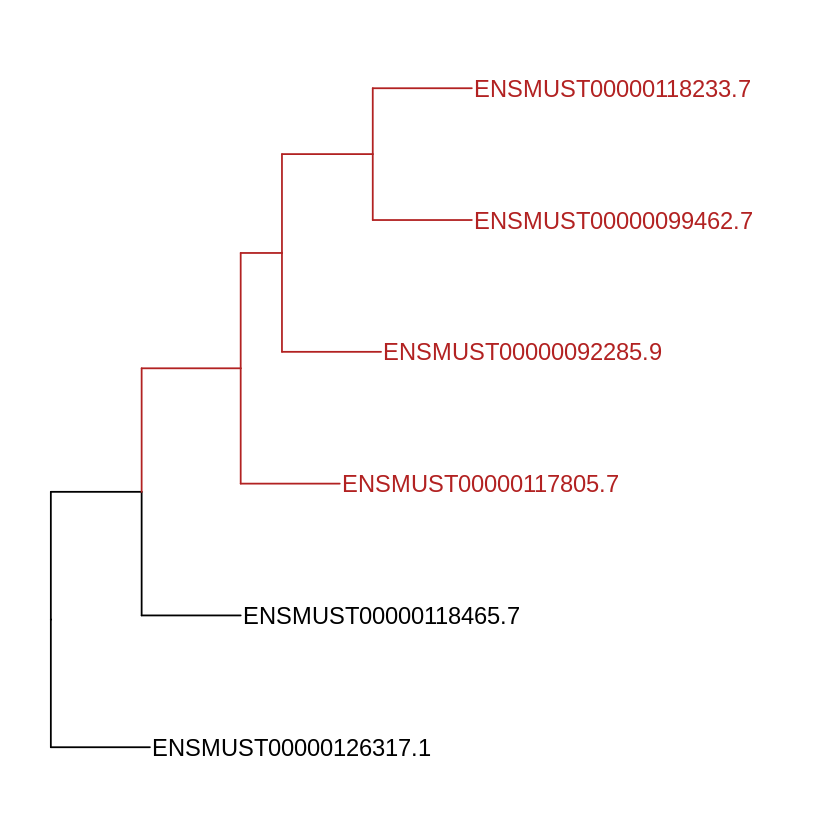

In [40]:
suppressPackageStartupMessages(library(ggtree))
suppressPackageStartupMessages(library("grid"))
suppressPackageStartupMessages(library("ggplotify"))

anc <- Ancestors(treeCons, iNode)
anc <- ifelse(length(anc)==1, iNode, anc[length(anc)-1])
treeSub <- treeio::tree_subset(treeCons, anc, levels_back = 0)
groupClade <- groupClade(treeSub, 9)
groupClade
pTree <- ggtree(groupClade, aes(color=group)) + theme(legend.position='none') +
    scale_color_manual(values=c("black", "firebrick")) + 
    geom_tiplab(size=5) + xlim(0, 90)
pTree

pTxp <- as.grob(~plotInfReps(y, "ENSMUST00000118233.7", "condition"))
pInn <- as.grob(~plotInfReps(yAll, iNode, "condition"))
#p <- ggtree(treeSub,  aes(color=group)) + geom_tiplab() + theme(legend.position='none') +  scale_color_manual(values=c("black", "firebrick")) + 

text[text1]

transcripts[transcripts1]

genomeLabel[genomeLabel1]

text[text2]

gg[gg1]

text[text2]

gg[gg2]

text[text2]

gg[gg3]



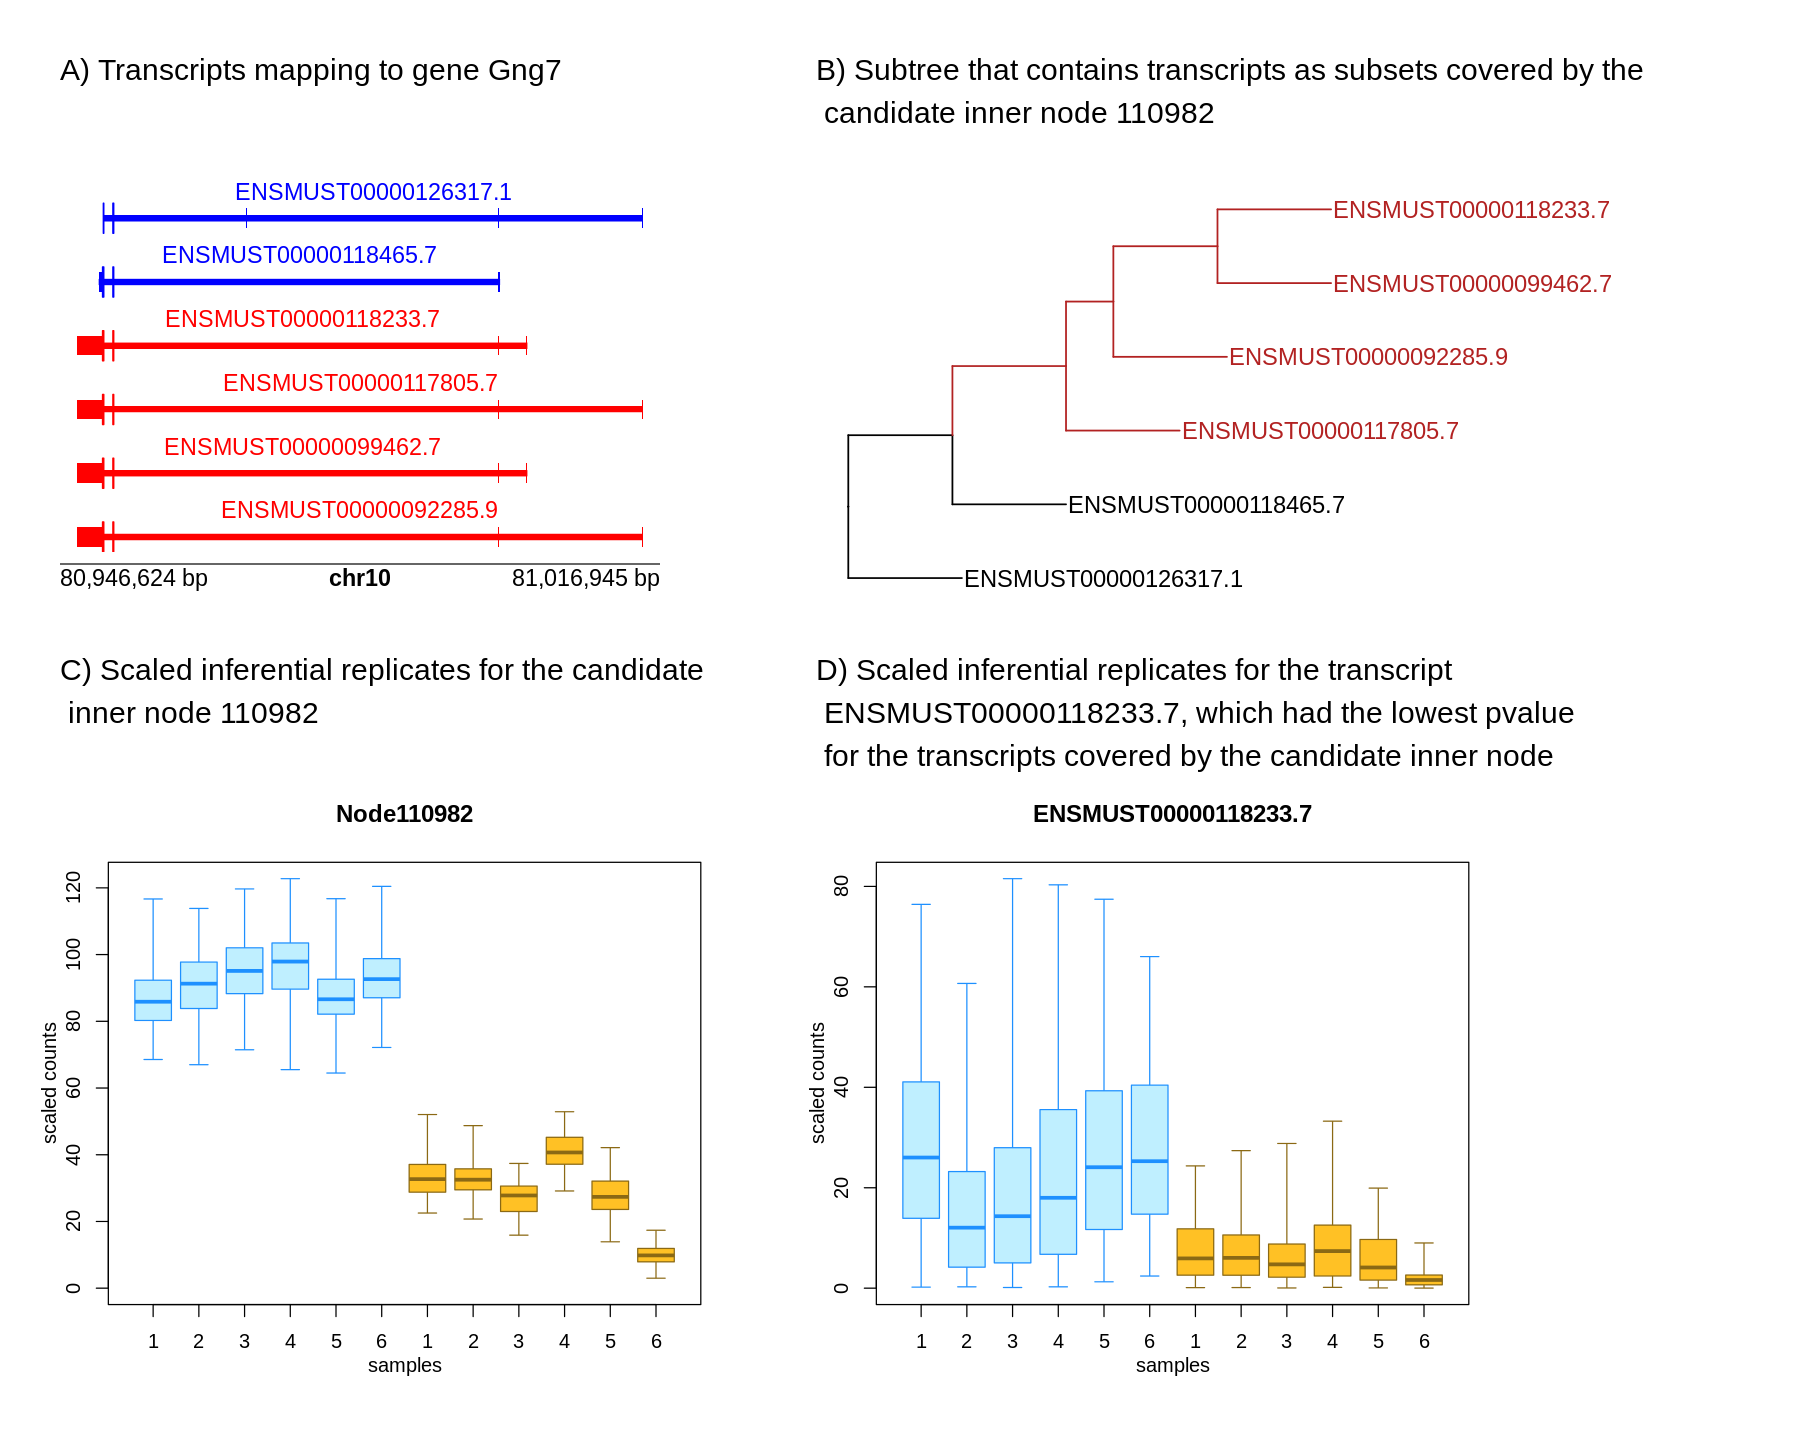

In [78]:
options(repr.plot.width=15, repr.plot.height=12)

library(plotgardener)
pageCreate(width = 15, height = 11.4, showGuides = FALSE, default.units = "inches")
par <- pgParams(
  chrom = "chr10", 
  chromstart = g[["start"]]-2000, chromend = g[["end"]]+2000,
  assembly = "mm10", just = c("left", "bottom"), fontsize = 8,
default.units = "inches", fontsize=14
)

parText <- pgParams(
    just = c("left", "top"), fontsize = 18
)#, fontface = "bold")

hilite <- data.frame(transcript=tx_to_show, color="red")
plotText(label="A) Transcripts mapping to gene Gng7", x = 0.5, y = 0.2,
        params = parText)

plotTranscripts(
    params = par, x = 0.5, y = 4.3, width = 5, height = 6, 
    spaceHeight=0.5, boxHeight=0.25,
    labels = "transcript", fill="blue", 
    transcriptHighlights = hilite
)
# plotRanges(
#     these_parts, fill="darkorchid",
#     params = par, x = 0.5, y = 8.5, width = 5, height = 5, 
#     spaceHeight = 0.4, boxHeight = 0.3
# )

plotGenomeLabel(
  params = par, x = 0.5, y = 4.4, length=5,
  just = c("left", "top")
)

plotText(label="B) Subtree that contains transcripts as subsets covered by the \n candidate inner node 110982", 
         x = 6.8, y = 0.2, params = parText)
plotGG(
    plot = pTree,
    x = 6.6, y = 1, width = 8, height=4
)
# plotGG(plotInfReps(yAll, 10, "condition"), x=0.5, y=8, width=4,height=4)

plotText(label="C) Scaled inferential replicates for the candidate \n inner node 110982", 
         x = 0.5, y = 5.2, params = parText)
plotGG(
    plot = pInn,
    x = 0.2, y = 6.3, width = 6, height=5
)

plotText(label="D) Scaled inferential replicates for the transcript \n ENSMUST00000118233.7, which had the lowest pvalue \n for the transcripts covered by the candidate inner node", 
         x = 6.8, y = 5.2, params = parText)
plotGG(
    plot = pTxp,
    x = 6.6, y = 6.3, width = 6, height=5
)


Attaching package: 'grid'


The following object is masked from 'package:Biostrings':

    pattern




In [125]:
BiocManager::install("gtree")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.20), R 4.3.0 (2023-04-21)

Installing package(s) 'gtree'

Warning message:
"package 'gtree' is not available for Bioconductor version '3.17'

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"
Old packages: 'BiocParallel', 'DelayedArray', 'sys'

